Imports

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 150)

Load the data and understand it

In [2]:
survey_df = pd.read_csv('/Users/naveedrafi/PycharmProjects/DS-Nanodegree/DS-Blog/Data/SO_dev_survey/survey_results_public.csv')
schema_df = pd.read_csv('/Users/naveedrafi/PycharmProjects/DS-Nanodegree/DS-Blog/Data/SO_dev_survey/survey_results_schema.csv')

# describe the data

# how many people have we surveyed?
print(survey_df.shape[0])

# how many questions did we ask?
print(schema_df.shape[0])

survey_df.describe()

51392
154


,Respondent,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,ExpectedSalary
count,51392.000000,42695.000000,40376.000000,20600.000000,36592.000000,12891.000000,2566.000000
mean,25696.500000,7.300574,6.957078,3.952282,8.429875,56298.480641,33142.220468
std,14835.736854,1.955444,2.167652,7.564722,1.390635,39880.905277,30162.988829
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12848.750000,6.000000,6.000000,1.000000,8.000000,26440.371839,4490.492484
50%,25696.500000,8.000000,7.000000,1.000000,9.000000,50000.000000,29364.263691
75%,38544.250000,9.000000,8.000000,4.000000,10.000000,80000.000000,50403.225806
max,51392.000000,10.000000,10.000000,40.000000,10.000000,197000.000000,187500.000000


List of column names

In [3]:
# list(survey_df.columns)

Sample data

In [4]:
survey_df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,CompanyType,YearsProgram,YearsCodedJob,YearsCodedJobPast,DeveloperType,WebDeveloperType,MobileDeveloperType,NonDeveloperType,CareerSatisfaction,JobSatisfaction,ExCoderReturn,ExCoderNotForMe,ExCoderBalance,ExCoder10Years,ExCoderBelonged,ExCoderSkills,ExCoderWillNotCode,ExCoderActive,PronounceGIF,ProblemSolving,BuildingThings,LearningNewTech,BoringDetails,JobSecurity,DiversityImportant,AnnoyingUI,FriendsDevelopers,RightWrongWay,UnderstandComputers,SeriousWork,InvestTimeTools,WorkPayCare,KinshipDevelopers,ChallengeMyself,CompetePeers,ChangeWorld,JobSeekingStatus,HoursPerWeek,LastNewJob,AssessJobIndustry,AssessJobRole,AssessJobExp,AssessJobDept,AssessJobTech,AssessJobProjects,AssessJobCompensation,AssessJobOffice,AssessJobCommute,AssessJobRemote,AssessJobLeaders,AssessJobProfDevel,AssessJobDiversity,AssessJobProduct,AssessJobFinances,ImportantBenefits,ClickyKeys,JobProfile,ResumePrompted,LearnedHiring,ImportantHiringAlgorithms,ImportantHiringTechExp,ImportantHiringCommunication,ImportantHiringOpenSource,ImportantHiringPMExp,ImportantHiringCompanies,ImportantHiringTitles,ImportantHiringEducation,ImportantHiringRep,ImportantHiringGettingThingsDone,Currency,Overpaid,TabsSpaces,EducationImportant,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,CousinEducation,WorkStart,HaveWorkedLanguage,WantWorkLanguage,HaveWorkedFramework,WantWorkFramework,HaveWorkedDatabase,WantWorkDatabase,HaveWorkedPlatform,WantWorkPlatform,IDE,AuditoryEnvironment,Methodology,VersionControl,CheckInCode,ShipIt,OtherPeoplesCode,ProjectManagement,EnjoyDebugging,InTheZone,DifficultCommunication,CollaborateRemote,MetricAssess,EquipmentSatisfiedMonitors,EquipmentSatisfiedCPU,EquipmentSatisfiedRAM,EquipmentSatisfiedStorage,EquipmentSatisfiedRW,InfluenceInternet,InfluenceWorkstation,InfluenceHardware,InfluenceServers,InfluenceTechStack,InfluenceDeptTech,InfluenceVizTools,InfluenceDatabase,InfluenceCloud,InfluenceConsultants,InfluenceRecruitment,InfluenceCommunication,StackOverflowDescribes,StackOverflowSatisfaction,StackOverflowDevices,StackOverflowFoundAnswer,StackOverflowCopiedCode,StackOverflowJobListing,StackOverflowCompanyPage,StackOverflowJobSearch,StackOverflowNewQuestion,StackOverflowAnswer,StackOverflowMetaChat,StackOverflowAdsRelevant,StackOverflowAdsDistracting,StackOverflowModeration,StackOverflowCommunity,StackOverflowHelpful,StackOverflowBetter,StackOverflowWhatDo,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,NaN,2 to 3 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"With a soft ""g,"" like ""jiff""",Strongly agree,Strongly agree,Agree,Disagree,Strongly agree,Agree,Agree,Disagree,Somewhat agree,Disagree,Strongly agree,Strongly agree,Strongly disagree,Agree,Agree,Disagree,Agree,"I'm not actively looking, but I am open to new opportunities",0.0,Not applicable/ never,Very important,Very important,Important,Very important,Very important,Very important,Important,Very important,Very important,Very important,Very important,Very important,Somewhat important,Not very important,Somewhat important,Stock options; Vacation/days off; Remote options,Yes,Other,NaN,NaN,Important,Important,Important,Somewhat important,Important,Not very important,Not very important,Not at all important,Somewhat important,Very important,NaN,NaN,Tabs,NaN,Online course; Open source contributions,NaN,NaN,NaN,6:00 AM,Swift,Swift,NaN,NaN,NaN,NaN,iOS,iOS,Atom; Xcode,Turn on some music,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat satisfied,Not very satisfied,Not at all satisfied,Very satisfied,Satisfied,Not very satisfied,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I have created a CV or Developer Story on Stack Overflow,9.0,Deskto

Function to get question description

In [277]:
# get the full question for a column

def get_question(col_name, schema_df):    
    return list(schema_df[schema_df['Column']==col_name]['Question'])[0]

In [278]:
# 'AuditoryEnvironment'
get_question('BoringDetails', schema_df)

'I tend to get bored by implementation details'

In [ ]:
# For this question, I will try to predict job satisfaction using a combination of numerical and categorical features from the survey

In [7]:
# Helper functions

def clean_fit_linear_mod(df, response_col, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test

    OUTPUT:
    X - cleaned X matrix (dummy and mean imputation)
    y - cleaned response (just dropped na)
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model

    This function cleans the data and provides the necessary output for the rest of this notebook.
    '''
    #Dropping where the salary has missing values
    df  = df.dropna(subset=['Salary'], axis=0)

    #Drop columns with all NaN values
    df = df.dropna(how='all', axis=1)

    #Pull a list of the column names of the categorical variables
    cat_df = df.select_dtypes(include=['object'])
    cat_cols = cat_df.columns

    #dummy all the cat_cols
    for col in  cat_cols:
        df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)], axis=1)


    # Mean function
    fill_mean = lambda col: col.fillna(col.mean())
    # Fill the mean
    df = df.apply(fill_mean, axis=0)

    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return X, y, test_score, train_score, lm_model, X_train, X_test, y_train, y_test


def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

In [15]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Drop rows with missing salary values
    df = df.dropna(subset=['JobSatisfaction'], axis=0)
    y = df['JobSatisfaction']
    
    #Drop respondent and expected salary columns
    df = df.drop(['Respondent', 'JobSatisfaction'], axis=1)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y
    
#Use the function to create X and y
X, y = clean_data(survey_df)   

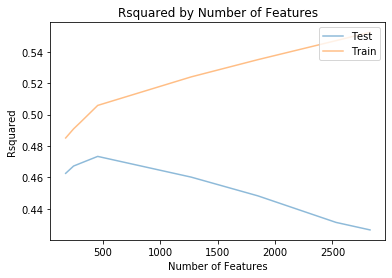

In [16]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

#Run this cell to pass your X and y to the model for testing
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [17]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
141,JobSeekingStatus_I am not interested in new job opportunities,0.947264,0.947264
237,Overpaid_Greatly underpaid,-0.746501,0.746501
0,CareerSatisfaction,0.667539,0.667539
142,"JobSeekingStatus_I'm not actively looking, but I am open to new opportunities",0.645834,0.645834
397,StackOverflowJobSearch_Haven't done at all,0.460606,0.460606
145,LastNewJob_More than 4 years ago,-0.378656,0.378656
193,ResumePrompted_I received bad news about the future of my company or depart,-0.321370,0.321370
143,LastNewJob_Between 2 and 4 years ago,-0.311269,0.311269
301,ProjectManagement_Strongly agree,-0.292609,0.292609
324,EquipmentSatisfiedRAM_Not very satisfied,-0.273398,0.273398
